In [1]:
using Random
using Distributions
using KernelDensity
using Statistics
using DataFrames
using XLSX
include("../Inversion/AffineInvariantMCMC.jl")
include("../Inversion/GMNVI.jl")
include("../Inversion/GMWVI.jl")
include("../Inversion/Plot.jl")
include("../Inversion/DF_GMVI.jl")
include("../Inversion/GMBBVI.jl")
include("../Inversion/NUTS.jl")
include("../Inversion/WALNUTS.jl")
include("./MultiModal_modified.jl")
include("../Inversion/initialize_with_annealing.jl")
Random.seed!(111);

## Gaussian likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A \theta
+\eta \quad (A = I)
\qquad 
y = 
\begin{bmatrix}
0.0\\
1.0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = I 
\end{align*}
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - A \theta}{\sigma_\eta}$$

     

## Circle shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\theta^T A \theta
+\eta \quad (A = I)
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 
\end{bmatrix} 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - \theta^T A \theta}{\sigma_\eta}$$

     
     
## Banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\lambda(\theta_{(2)} -  \theta_{(1)}^2)\\
\theta_{(1)}
\end{bmatrix}
+\eta \quad (\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I \qquad (\sigma_\eta = 0.3)
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \lambda(\theta_{(2)} -  \theta_{(1)}^2)}{\sigma_\eta}\\
\frac{y_{(2)} - \theta_{(1)}}{\sigma_\eta}
\end{bmatrix}$$
     
     
## Double banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)\\ 
\theta_{(1)}\\ 
\theta_{(2)}
\end{bmatrix}
+ \eta \quad(\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
\log(\lambda+1)\\
0\\
0
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 & \\
& 1^2   \\
& & 1^2
\end{bmatrix}  
\end{align*}
$$

We essentially focus on the prior $\mathcal{N}(0,I)$, and we are sampling 
$e^{-\frac{1}{2}F^TF}$ 
with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)}{\sigma_\eta}\\
y_{(2)} - \theta_{(1)}\\
y_{(3)} - \theta_{(2)}
\end{bmatrix}$$

In [2]:
function Gaussian_mixture_NGFVI(func_V, w0, μ0, Σ0; diagonal_covariance::Bool = false,  Hessian_correct_GM::Bool = false, N_ens = -1, N_ens_GM = -1, N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    
    if N_ens == -1  N_ens = 2*N_θ+1   end

    T =  N_iter * dt
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    
    objs = []

    gmnviobj = GMNVI_Run(
    func_V, 
    T,
    N_iter,
    # Initial condition
    x0_w, x0_mean, xx0_cov;
    sqrt_matrix_type = sqrt_matrix_type,
    diagonal_covariance = diagonal_covariance,
    # setup for Gaussian mixture part
    quadrature_type_GM = "mean_point",
    # setup for potential function part
    quadrature_type = "mean_point",
    Hessian_correct_GM = Hessian_correct_GM,
    N_ens = N_ens)
    
    push!(objs, gmnviobj)


    return objs
end



# 新增辅助函数：计算高斯混合模型的期望和协方差
function calculate_gm_stats(weights, means, covs)
    # 确保权重归一化
    w = weights / sum(weights)
    N_modes, N_θ = size(means)

    # 计算总期望 (mean)
    total_mean = zeros(N_θ)
    for i in 1:N_modes
        total_mean += w[i] * means[i, :]
    end

    # 计算总协方差 (variance)
    # Cov[X] = E[Cov[X|Z]] + Cov[E[X|Z]]
    # E[Cov[X|Z]] = Σ(w_i * Σ_i)
    # Cov[E[X|Z]] = Σ(w_i * μ_i * μ_i') - E[X]E[X]'
    e_cov = zeros(N_θ, N_θ)
    cov_e = zeros(N_θ, N_θ)
    for i in 1:N_modes
        e_cov += w[i] * covs[i, :, :]
        cov_e += w[i] * (means[i, :] * means[i, :]')
    end
    total_cov = e_cov + cov_e - (total_mean * total_mean')
    
    return total_mean, total_cov
end

# 新增辅助函数：计算样本的期望和协方差
function calculate_sample_stats(samples)
    # samples: N_θ x N_samples
    if isempty(samples) || size(samples, 2) < 2
        return fill(NaN, size(samples, 1)), fill(NaN, size(samples, 1), size(samples, 1))
    end
    # 使用 Statistics.mean 和 Statistics.cov
    total_mean = mean(samples, dims=2)[:, 1]
    total_cov = cov(samples') # cov 需要变量在列上，所以转置
    return total_mean, total_cov
end



function Gaussian_mixture_NGFVI(func_V, w0, μ0, Σ0; diagonal_covariance::Bool = false,  Hessian_correct_GM::Bool = false, N_ens = -1, N_ens_GM = -1, N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    
    if N_ens == -1  N_ens = 2*N_θ+1   end

    T =  N_iter * dt
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    
    objs = []

    gmnviobj = GMNVI_Run(
    func_V, 
    T,
    N_iter,
    # Initial condition
    x0_w, x0_mean, xx0_cov;
    sqrt_matrix_type = sqrt_matrix_type,
    diagonal_covariance = diagonal_covariance,
    # setup for Gaussian mixture part
    quadrature_type_GM = "mean_point",
    # setup for potential function part
    quadrature_type = "mean_point",
    Hessian_correct_GM = Hessian_correct_GM,
    N_ens = N_ens)
    
    push!(objs, gmnviobj)


    return objs
end



# 新增辅助函数：计算高斯混合模型的期望和协方差
function calculate_gm_stats(weights, means, covs)
    # 确保权重归一化
    w = weights / sum(weights)
    N_modes, N_θ = size(means)

    # 计算总期望 (mean)
    total_mean = zeros(N_θ)
    for i in 1:N_modes
        total_mean += w[i] * means[i, :]
    end

    # 计算总协方差 (variance)
    # Cov[X] = E[Cov[X|Z]] + Cov[E[X|Z]]
    # E[Cov[X|Z]] = Σ(w_i * Σ_i)
    # Cov[E[X|Z]] = Σ(w_i * μ_i * μ_i') - E[X]E[X]'
    e_cov = zeros(N_θ, N_θ)
    cov_e = zeros(N_θ, N_θ)
    for i in 1:N_modes
        e_cov += w[i] * covs[i, :, :]
        cov_e += w[i] * (means[i, :] * means[i, :]')
    end
    total_cov = e_cov + cov_e - (total_mean * total_mean')
    
    return total_mean, total_cov
end

# 新增辅助函数：计算样本的期望和协方差
function calculate_sample_stats(samples)
    # samples: N_θ x N_samples
    if isempty(samples) || size(samples, 2) < 2
        return fill(NaN, size(samples, 1)), fill(NaN, size(samples, 1), size(samples, 1))
    end
    # 使用 Statistics.mean 和 Statistics.cov
    total_mean = mean(samples, dims=2)[:, 1]
    total_cov = cov(samples') # cov 需要变量在列上，所以转置
    return total_mean, total_cov
end



function visualization_comparison_2d(ax, obj_GMNVI, obj_GMNVI_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
        func_F = nothing, func_Phi = nothing, bandwidth=nothing, make_label::Bool=false, N_iter=500)

        x_min, x_max = x_lim
        y_min, y_max = y_lim

        xx = LinRange(x_min, x_max, Nx)
        yy = LinRange(y_min, y_max, Ny)
        dx, dy = xx[2] - xx[1], yy[2] - yy[1]
        X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

        Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
        color_lim = (minimum(Z_ref), maximum(Z_ref))
        ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

        error = zeros(7, N_iter+1)

        # NGF-VI
        if obj_GMNVI!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMNVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMNVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMNVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[1, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                        ax[2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[2].scatter([obj_GMNVI.x_mean[1][:,1];], [obj_GMNVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[2].text(0.05, 0.95, text_str, transform=ax[2].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # NGF-VI-D
        if obj_GMNVI_D!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMNVI_D.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMNVI_D.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMNVI_D.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[2, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                        ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[3].scatter([obj_GMNVI_D.x_mean[1][:,1];], [obj_GMNVI_D.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[3].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[3].text(0.05, 0.95, text_str, transform=ax[3].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # GMWVI
        if obj_GMWVI!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMWVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMWVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMWVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[3, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                        ax[4].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[4].scatter([obj_GMWVI.x_mean[1][:,1];], [obj_GMWVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[4].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[4].text(0.05, 0.95, text_str, transform=ax[4].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # GMBBVI
        if obj_GMBBVI !=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMBBVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMBBVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMBBVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[4, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                        ax[5].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[5].scatter([obj_GMBBVI.x_mean[1][:,1];], [obj_GMBBVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[5].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[5].text(0.05, 0.95, text_str, transform=ax[5].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # MCMC
        if ens_MCMC!=nothing
                boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
                for iter = 0:N_iter
                if bandwidth==nothing
                        kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny))
                else
                        kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                end

                Z = kde_iter.density
                sum_Z = sum(Z)
                if sum_Z > 0 Z ./= (sum_Z*dx*dy) end
                error[5, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                        last_n_iters=10
                        last_ens=hcat([ens_MCMC[:,:,i] for i in N_iter+2-last_n_iters:N_iter+1]...)
                        last_ens_number=size(last_ens,2)

                        if bandwidth==nothing
                        kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny))
                        else
                        kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny), bandwidth=bandwidth)
                        end

                        Z = kde_last.density
                        sum_Z = sum(Z)
                        if sum_Z > 0 Z ./= (sum_Z*dx*dy) end

                        ax[6].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[6].scatter(last_ens[1,:], last_ens[2,:], marker=".", color="red", s=10, alpha=100/last_ens_number)
                        ax[6].set_xlim(x_lim)
                        ax[6].set_ylim(y_lim)
                        
                        mean_val, cov_val = calculate_sample_stats(last_ens[1:2, :])
                        if !any(isnan, mean_val)
                            text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                            ax[6].text(0.05, 0.95, text_str, transform=ax[6].transAxes, fontsize=8,
                                       verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                        end
                        end
                end
        end

        # NUTS Error Calculation
        if ens_NUTS!=nothing
                boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
                samples_per_iter = 100
                total_samples = size(ens_NUTS, 2)
                for iter = 0:N_iter
                        n_samples_end = min((iter + 1) * samples_per_iter, total_samples)
                        if n_samples_end < 2
                                error[6, iter+1] = NaN
                                continue
                        end
                        samples_iter = ens_NUTS[:, 1:n_samples_end]
                        
                        if bandwidth==nothing
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny))
                        else
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                        end
        
                        Z = kde_iter.density
                        sum_Z = sum(Z)
                        if sum_Z > 0 Z ./= (sum_Z*dx*dy) end
                        error[6, iter+1] = norm(Z - Z_ref,1)*dx*dy
                end
        end
        
        # WALNUTS Error Calculation
        if ens_WALNUTS!=nothing
                boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
                samples_per_iter = 100
                total_samples = size(ens_WALNUTS, 2)
                for iter = 0:N_iter
                        n_samples_end = min((iter + 1) * samples_per_iter, total_samples)
                        if n_samples_end < 2
                                error[7, iter+1] = NaN
                                continue
                        end
                        samples_iter = ens_WALNUTS[:, 1:n_samples_end]

                        if bandwidth==nothing
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny))
                        else
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                        end
        
                        Z = kde_iter.density
                        sum_Z = sum(Z)
                        if sum_Z > 0 Z ./= (sum_Z*dx*dy) end
                        error[7, iter+1] = norm(Z - Z_ref,1)*dx*dy
                end
        end
    
        # Helper for plotting final MCMC-type distributions
        function plot_mcmc_on_ax(ax_plt, samples, title)
            if samples === nothing || size(samples, 2) < 20
                ax_plt.text(0.5, 0.5, "No Samples", ha="center", va="center")
                ax_plt.set_title(title)
                ax_plt.set_xlim(x_lim)
                ax_plt.set_ylim(y_lim)
                return
            end
        
            ax_plt.set_title(title)
        
            burn_in = div(size(samples, 2), 2)
            samples_to_plot = samples[:, burn_in+1:end]
        
            if size(samples_to_plot, 2) < 2
                ax_plt.text(0.5, 0.5, "No Samples Post Burn-in", ha="center", va="center")
                return
            end

            kde_boundary = ((x_lim[1], x_lim[2]), (y_lim[1], y_lim[2]))
        
            kde_res = kde(samples_to_plot', boundary=kde_boundary, npoints=(Nx, Ny), bandwidth=bandwidth)
            Z_kde = kde_res.density
            if sum(Z_kde) > 0 Z_kde ./= sum(Z_kde) * dx * dy end
            ax_plt.pcolormesh(X, Y, Z_kde, cmap="viridis", vmin=color_lim[1], vmax=color_lim[2])
        
            alpha_val = min(1.0, 100 / size(samples_to_plot, 2))
            ax_plt.scatter(samples_to_plot[1, :], samples_to_plot[2, :], 
                           marker=".", color="red", s=10, alpha=alpha_val)

            samples_2d = samples_to_plot[1:2, :]
            mean_val, cov_val = calculate_sample_stats(samples_2d)
            
            if !any(isnan, mean_val) && !any(isnan, cov_val)
                text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                ax_plt.text(0.05, 0.95, text_str, transform=ax_plt.transAxes, fontsize=8,
                           verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
            end
        
            ax_plt.set_xlim(x_lim)
            ax_plt.set_ylim(y_lim)
        end

    # Plot final distributions for NUTS and WALNUTS to ax[7] and ax[8]
    plot_mcmc_on_ax(ax[7], ens_NUTS, "NUTS")
    plot_mcmc_on_ax(ax[8], ens_WALNUTS, "WALNUTS")

    # Error plot on ax[9]
    ax[9].semilogy(Array(0:N_iter), error', label=["NGF-VI","NGF-VI-D","WGF-VI","GMBBVI","MCMC","NUTS","WALNUTS"])   

    if make_label==true
            ax[9].legend()
    end

    ymin, ymax = ax[9].get_ylim()
    if ymin > 0.1
            ax[9].set_ylim(0.1, ymax)
    end
end


# 新增函数：绘制方差收敛图
function plot_variance_convergence(obj_GMNVI, obj_GMNVI_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS; N_iter=500, filename="variance_convergence.pdf")
    
    # 初始化存储方差的数组，维度1为θ₁的方差，维度2为θ₂的方差
    labels = ["NGF-VI", "NGF-VI-D", "WGF-VI", "GMBBVI", "MCMC", "NUTS", "WALNUTS"]
    variances = Dict(label => fill(NaN, 2, N_iter + 1) for label in labels)
    
    # 迭代计算每个方法的方差
    for iter in 0:N_iter
        # --- 变分推断方法 ---
        # NGF-VI
        if obj_GMNVI !== nothing
            w = exp.(obj_GMNVI.logx_w[iter+1]); w /= sum(w)
            m = obj_GMNVI.x_mean[iter+1][:,1:2]
            c = obj_GMNVI.xx_cov[iter+1][:,1:2,1:2]
            _, total_cov = calculate_gm_stats(w, m, c)
            variances["NGF-VI"][:, iter+1] .= [total_cov[1,1], total_cov[2,2]]
        end

        # NGF-VI-D
        if obj_GMNVI_D !== nothing
            w = exp.(obj_GMNVI_D.logx_w[iter+1]); w /= sum(w)
            m = obj_GMNVI_D.x_mean[iter+1][:,1:2]
            c = obj_GMNVI_D.xx_cov[iter+1][:,1:2,1:2]
            _, total_cov = calculate_gm_stats(w, m, c)
            variances["NGF-VI-D"][:, iter+1] .= [total_cov[1,1], total_cov[2,2]]
        end

        # GMWVI
        if obj_GMWVI !== nothing
            w = exp.(obj_GMWVI.logx_w[iter+1]); w /= sum(w)
            m = obj_GMWVI.x_mean[iter+1][:,1:2]
            c = obj_GMWVI.xx_cov[iter+1][:,1:2,1:2]
            _, total_cov = calculate_gm_stats(w, m, c)
            variances["WGF-VI"][:, iter+1] .= [total_cov[1,1], total_cov[2,2]]
        end
        
        # GMBBVI
        if obj_GMBBVI !== nothing
            w = exp.(obj_GMBBVI.logx_w[iter+1]); w /= sum(w)
            m = obj_GMBBVI.x_mean[iter+1][:,1:2]
            c = obj_GMBBVI.xx_cov[iter+1][:,1:2,1:2]
            _, total_cov = calculate_gm_stats(w, m, c)
            variances["GMBBVI"][:, iter+1] .= [total_cov[1,1], total_cov[2,2]]
        end

        # --- MCMC 类型方法 ---
        # MCMC
        if ens_MCMC !== nothing
            # 累积到当前迭代的所有样本
            samples_so_far = hcat([ens_MCMC[:,:,i] for i in 1:iter+1]...)
            if size(samples_so_far, 2) >= 2
                _, total_cov = calculate_sample_stats(samples_so_far[1:2, :])
                if !any(isnan, total_cov)
                    variances["MCMC"][:, iter+1] .= [total_cov[1,1], total_cov[2,2]]
                end
            end
        end

        # NUTS
        if ens_NUTS !== nothing
            samples_per_iter = 100 # 与误差计算部分保持一致
            n_samples_end = min((iter + 1) * samples_per_iter, size(ens_NUTS, 2))
            if n_samples_end >= 2
                samples_iter = ens_NUTS[:, 1:n_samples_end]
                _, total_cov = calculate_sample_stats(samples_iter[1:2, :])
                if !any(isnan, total_cov)
                    variances["NUTS"][:, iter+1] .= [total_cov[1,1], total_cov[2,2]]
                end
            end
        end

        # WALNUTS
        if ens_WALNUTS !== nothing
            samples_per_iter = 100 # 与误差计算部分保持一致
            n_samples_end = min((iter + 1) * samples_per_iter, size(ens_WALNUTS, 2))
            if n_samples_end >= 2
                samples_iter = ens_WALNUTS[:, 1:n_samples_end]
                _, total_cov = calculate_sample_stats(samples_iter[1:2, :])
                if !any(isnan, total_cov)
                    variances["WALNUTS"][:, iter+1] .= [total_cov[1,1], total_cov[2,2]]
                end
            end
        end
    end
    
    # 创建新的独立图窗
    fig_var, ax_var = PyPlot.subplots(nrows=2, ncols=1, sharex=true, figsize=(12, 10))
    
    # 绘制θ₁的方差收敛图
    for label in labels
        if !all(isnan, variances[label][1, :])
             ax_var[1].plot(0:N_iter, variances[label][1, :], label=label)
        end
    end
    ax_var[1].set_title("Variance Convergence for θ₁")
    ax_var[1].set_ylabel("Variance")
    ax_var[1].grid(true)
    ax_var[1].legend()

    # 绘制θ₂的方差收敛图
    for label in labels
        if !all(isnan, variances[label][2, :])
            ax_var[2].plot(0:N_iter, variances[label][2, :], label=label)
        end
    end
    ax_var[2].set_title("Variance Convergence for θ₂")
    ax_var[2].set_xlabel("Iteration")
    ax_var[2].set_ylabel("Variance")
    ax_var[2].grid(true)
    ax_var[2].legend()

    fig_var.tight_layout()
    fig_var.savefig(filename)
    PyPlot.close(fig_var) # 关闭图窗以释放内存
end

plot_variance_convergence (generic function with 1 method)

# Test the aforementioned examples with different methods

[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)


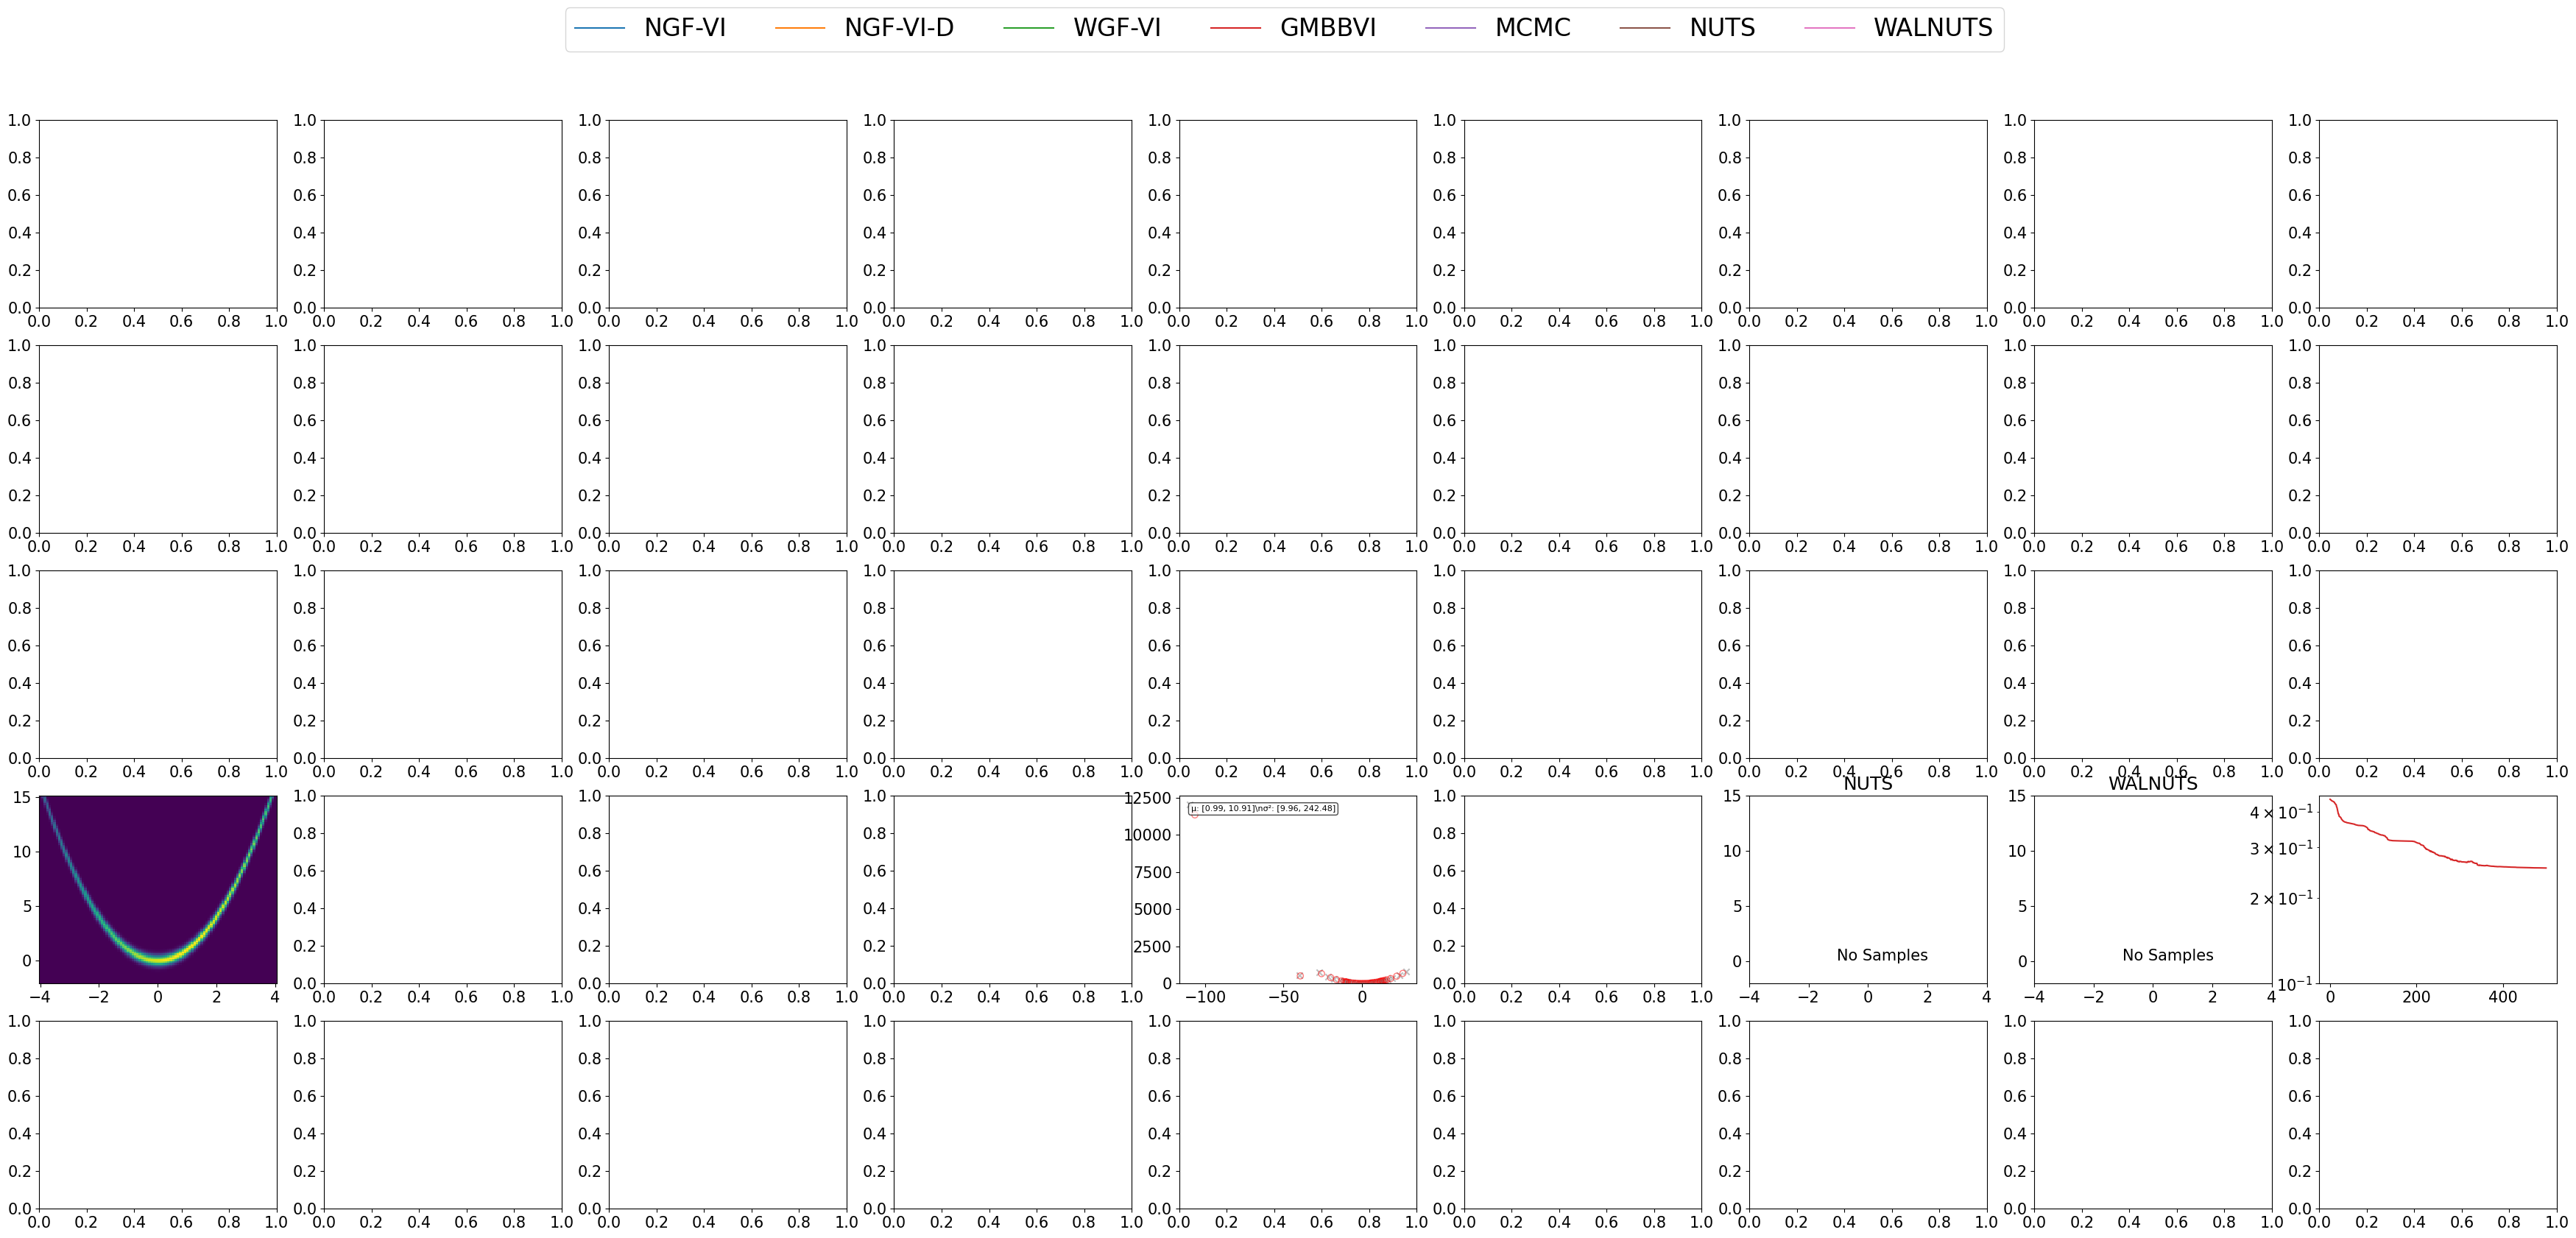

In [8]:
# Test the examples in MultiModal-DFGMVI.ipynb with different methods

N_modes = 40 # number of modes in Gaussian mixture
N_ens= 1000 # number of paticles in MCMC
N_bbvi_sample = 5 # number of samples to compute expectation using Monte Carlo in GMBBVI

fig, ax = PyPlot.subplots(nrows=5, ncols=9, sharex=false, sharey=false, figsize=(36,17))


Random.seed!(111);
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
Hessian_correct_GM = false
ens_0=zeros(N_x,N_ens)
for j = 1:N_ens
    ens_0[:,j]  = rand(MvNormal(zeros(N_x), Σ0)) + μ0
end

N_iter = 500
Nx, Ny = 100,100



# ση = 1.0
# Gtype = "Gaussian"
# dt1 = dt3 = dt4 = 0.5
# dt2 = 1.4e-1 
# A = [1.0 1.0; 1.0 2.0]
# y = [0.0; 1.0; zeros(N_x-2)]
# func_args = (y, ση, A , Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x)=exp(logrho(x, func_args))
# func_Phi(x)= -logrho(x, func_args)

# obj_NGFlow = nothing
# obj_NGFlow_D = nothing
# obj_GMWVI = nothing
# # obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
# # obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3, Hessian_correct_GM=Hessian_correct_GM)[1]
# # obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_GMBBVI = Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample
# ,annealing_enable = true, 
#     T_start = 70.0,          
#     annealing_frac = 0.5)
# ens_MCMC = nothing
# # ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

# println("Running HMC for Gaussian...")
# ∇U_func_hmc(x) = ∇U_for_HMC(x, func_args) # 使用在 MultiModal.jl 中定义的全局函数
# ens_NUTS = nothing
# ens_WALNUTS = nothing
# # ens_NUTS = Run_NUTS_with_warmup(func_Phi, ∇U_func_hmc, μ0; N_iter=N_ens*50, N_warmup=div(N_ens, 1), δ_target=0.8)
# # ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, ∇U_func_hmc; N_iter=N_ens*50, h=0.8, δ=0.2)

# visualization_comparison_2d(ax[1,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS; 
#                           Nx=Nx, Ny=Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_Phi=func_Phi, 
#                           bandwidth=(0.32,0.22), make_label=false, N_iter=N_iter)



# ση = 1.0
# Gtype = "Four_modes"
# dt1 = dt3 = dt4 = 0.5
# dt2 = 5e-3
# y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
# func_args = (y, ση, 0, Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x)=exp(logrho(x, func_args))
# func_Phi(x)= -logrho(x, func_args)
# x0_w, x0_mean, xx0_cov = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 0.5, N_ens=N_bbvi_sample
#     , factor = 3.0)


# obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_GMBBVI = Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
# ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

# println("  -> Running HMC methods for Four_modes...")
# ∇U_func_hmc(x) = ∇U_for_HMC(x, func_args)
# # --- 修正参数顺序 ---
# ens_NUTS = Run_NUTS_with_warmup(func_Phi, ∇U_func_hmc, μ0; N_iter=N_ens*50, N_warmup=div(N_ens,1), δ_target=0.65)
# ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, ∇U_func_hmc; N_iter=N_ens*50, h=0.4, δ=0.4) # 参数适中

# visualization_comparison_2d(ax[2,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS;
#                           Nx=Nx, Ny=Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_Phi=func_Phi, 
#                           bandwidth=(0.14,0.14), make_label=false, N_iter=N_iter)




# ση = [0.3; ones(N_x-2)]
# Gtype = "Circle"
# dt1 = dt3 = dt4 = 0.5
# dt2 = 5e-3
# A = [1.0 0.0; 0.0 1.0]
# y = [1.0; zeros(N_x-2)]
# func_args = (y, ση, A , Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x)=exp(logrho(x, func_args))
# func_Phi(x)= -logrho(x, func_args)

# obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_GMBBVI = Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample
# ,annealing_enable = true, 
#     T_start = 40.0,          
#     annealing_frac = 0.9)
# ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

# println("  -> Running HMC methods for Circle...")
# ∇U_func_hmc(x) = ∇U_for_HMC(x, func_args)
# # --- 修正参数顺序 ---
# ens_NUTS = Run_NUTS_with_warmup(func_Phi, ∇U_func_hmc, μ0; N_iter=N_ens*50, N_warmup=div(N_ens,1), δ_target=0.65)
# ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, ∇U_func_hmc; N_iter=N_ens*50, h=0.3, δ=0.2) # 几何约束强，步长不宜过大

# visualization_comparison_2d(ax[3,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS;
#                           Nx=Nx, Ny=Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_Phi=func_Phi, 
#                           bandwidth=(0.20,0.14), make_label=false, N_iter=N_iter)



ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
Gtype = "Banana"
dt1 = dt3 = dt4 = 0.5
dt2 = 4e-3
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)
x0_w, x0_mean, xx0_cov = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 0.5, N_ens=N_bbvi_sample
    , factor = 3.0)

obj_NGFlow = nothing
obj_NGFlow_D = nothing
obj_GMWVI = nothing

# obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_GMBBVI = Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
ens_MCMC = nothing
# ens_MCMC = Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

∇U_func_hmc(x) = ∇U_for_HMC(x, func_args)
ens_NUTS = nothing
ens_WALNUTS = nothing
# ens_NUTS = Run_NUTS_with_warmup(func_Phi, ∇U_func_hmc, μ0; N_iter=N_ens*50, N_warmup=div(N_ens,2), δ_target=0.65)
# ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, ∇U_func_hmc; N_iter=N_ens*50, h=0.6, δ=0.7) 

visualization_comparison_2d(ax[4,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS;
                          Nx=Nx, Ny=Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 15.0], func_Phi=func_Phi, 
                          bandwidth=(0.06,0.11), make_label=false, N_iter=N_iter)


# # 检查 GMBBVI 对象是否存在
# if @isdefined(obj_GMBBVI) && obj_GMBBVI !== nothing
#     # --- 1. 数据准备 (与之前相同) ---
#     final_log_weights = obj_GMBBVI.logx_w[end]
#     final_means = obj_GMBBVI.x_mean[end]
#     final_covs = obj_GMBBVI.xx_cov[end]
#     final_weights = exp.(final_log_weights)
#     final_weights ./= sum(final_weights)
#     N_modes_final = length(final_weights)


#     # 1. 计算 GMM 在 x 维度上的总均值 (total_mean_x)
#     #    它是所有模态均值 (final_means[:, 2]) 的加权平均
#     total_mean_x = dot(final_weights, final_means[:, 2])

#     # 2. 计算 GMM 在 x 维度上的总方差 (total_var_x)
#     #    总方差 = 内部方差的期望 + 均值之间的方差
#     #    E[Var(x|k)] = Σ w_k * C_k(x,x)
#     internal_var_exp = dot(final_weights, [final_covs[i, 2, 2] for i in 1:N_modes_final])
#     #    Var(E[x|k]) = Σ w_k * (μ_k(x) - μ_total(x))²
#     between_means_var = dot(final_weights, (final_means[:, 2] .- total_mean_x).^2)
#     #    总方差
#     total_var_x = internal_var_exp + between_means_var

    
#     # --- 2. 创建 DataFrames (与之前相同) ---

#     # 计算每个模式的贡献
#     contributions_internal = final_weights .* [final_covs[i, 2, 2] for i in 1:N_modes_final]
#     contributions_between = final_weights .* (final_means[:, 2] .- total_mean_x).^2
#     contributions_total = contributions_internal .+ contributions_between

#     # 计算贡献的百分比
#     percent_contributions = (contributions_total / total_var_x) * 100

#     df_components = DataFrame(
#         Mode = 1:N_modes_final,
#         Weight = final_weights,
#         Mean_ω = final_means[:, 1],
#         Mean_x = final_means[:, 2],
#         Cov_xx = [final_covs[i, 2, 2] for i in 1:N_modes_final],
#         Contribution_Internal = contributions_internal,
#         Contribution_Between = contributions_between,
#         Contribution_Total = contributions_total,
#         Contribution_Percent = percent_contributions
#         )
#     total_mean_gmbvvi, total_cov_gmbvvi = calculate_gm_stats(final_weights, final_means, final_covs)
#     df_stats = DataFrame(
#         Description = ["Total Mean", "Total Covariance (Row 1)", "Total Covariance (Row 2)"],
#         Value_ω = [total_mean_gmbvvi[1], total_cov_gmbvvi[1, 1], total_cov_gmbvvi[2, 1]],
#         Value_x = [total_mean_gmbvvi[2], total_cov_gmbvvi[1, 2], total_cov_gmbvvi[2, 2]]
#     )
    
#     # --- 3. 写入 Excel 文件  ---
#     excel_filename = "gmbvvi_N_modes_$(N_modes).xlsx"
    
#     # 使用 "w" (write) 模式。这将覆盖任何现有文件。
#     XLSX.openxlsx(excel_filename, mode="w") do xf
#         # 添加第一个工作表并写入数据
#         sheet1 = XLSX.addsheet!(xf, "Component Details")
#         XLSX.writetable!(sheet1, df_components)
#         println("Component details written to sheet 'Component Details'.")
        
#         # 添加第二个工作表并写入数据
#         sheet2 = XLSX.addsheet!(xf, "Overall Stats")
#         XLSX.writetable!(sheet2, df_stats)
#         println("Overall stats written to sheet 'Overall Stats'.")
#     end
    
#     println("Excel file '$excel_filename' has been successfully created/updated.")

# else
#     println("obj_GMBBVI is not defined or is nothing. No file was created.")
# end

# println("="^55 * "\n") 




# ση = [0.3; 1.0; 1.0; ones(N_x-2)]
# Gtype = "Double_banana"
# dt1 = dt3 = dt4 = 0.5
# dt2 = 8e-4
# λ = 100.0
# y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
# func_args = (y, ση, λ , Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x)=exp(logrho(x, func_args))
# func_Phi(x)= -logrho(x, func_args)
# x0_w, x0_mean, xx0_cov = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 0.5, N_ens=N_bbvi_sample
#     , factor = 3.0)

# obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM = Hessian_correct_GM)[1]
# obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3, Hessian_correct_GM = Hessian_correct_GM)[1]
# obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
# obj_GMBBVI = Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
# ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

# println("  -> Running HMC methods for Double_banana...")
# ∇U_func_hmc(x) = ∇U_for_HMC(x, func_args)
# # --- 修正参数顺序 ---
# ens_NUTS = Run_NUTS_with_warmup(func_Phi, ∇U_func_hmc, μ0; N_iter=N_ens*50, N_warmup=div(N_ens,1), δ_target=0.65)
# ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, ∇U_func_hmc; N_iter=N_ens*50, h=0.4, δ=0.9) # 最具挑战性，WALNUTS需要大δ

# visualization_comparison_2d(ax[5,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS;
#                           Nx=Nx, Ny=Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_Phi=func_Phi, 
#                           bandwidth=(0.06,0.11), make_label=true, N_iter=N_iter)

plot_variance_convergence(obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS;
                          N_iter=N_iter, filename="MultiModal-Comparison-Variance-Convergence.pdf")

handles, labels = ax[end-1, end].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=7,fontsize=24)
fig.subplots_adjust(bottom=0.03,top=0.9,left=0.03,right=0.98,hspace=0.2) 

fig.savefig("MultiModal-Comparison-2D-Final.pdf")
